# ET Homework - gaze data simulation. Extra points.
## Student: Emmanuel Bustos, 320530

### Import libraries and declare constants
This section is for the configuration of the data generator. The parameters of the data generator are shown with their respective units and also with some clarifying information when necessary. Also, the libraries necessary for the generator to work are imported. 

In [15]:
import random
from math import cos, sin, atan2, degrees, sqrt
import numpy as np
import matplotlib.pyplot as plt

# Parameters
MONITOR_PIXELS = (1024, 768) # px
MONITOR_DIMENSIONS = (42.87, 31.7) # cm
DISTANCE = 60 # cm (distance from the participant to the screen)
SAMPLING_RATE = 500 # Hz
SAMPLING_TIME = 2 # s
FIXATION_TIME = (100, 250) # range of the fixation time in ms
SACCADE_VEL = (300, 500) # range of the saccade velocity in deg/s
SACC_NOISE_SD = 5 # Standard deviation of saccade noise in px
FIX_NOISE_SD = (10, 5) # Vertical and horizontal Standard deviation of fixation noise in px


### Saccade generator.
This section contains two functions:
- sacc_pixels(sacc_velocity): This function contains the distance in pixels between two sampling points in a saccade of velocity *sacc_velocity*. It utilizes several parameters from the system such as the sample rate and the monitor characteristics. The return value is a float corresponding to the number of pixels between each sampling point.
- generate_saccade(start_point, end_point): This function generates a series of points between a starting point *start_point* and an ending point *end_point* corresponding to a saccade between such points. The saccade velocity varies randomly between each point according to the specified saccade velocity range. Also, some Gaussian noise with standard deviation of *NOISE_SD* is added to each point of the saccade. The return value is a numpy array with two rows, the first containing all the X coordinates of the saccade points and the second one containing the Y coordinates.

At the end of this section one data visualization is shown. It is a scatter plot corresponding to the points of the generated saccade data.

Text(0, 0.5, 'y position (px)')

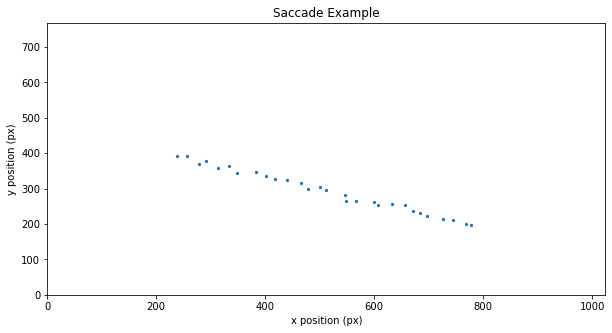

In [16]:
def sacc_pixels(sacc_velocity):
    '''Given sacc_velocity, give the distance in pixels between two points 
    according to the sampling rate (SAMPLING_RATE).
    
    Parameters:
    sacc_velocity: Saccade velocity in degrees per second
    '''
    size_in_deg = sacc_velocity/SAMPLING_RATE # The stimulus size in pixels
    # Calculate the number of degrees that correspond to a single pixel. This will
    # generally be a very small value, something like 0.03.
    deg_per_px = degrees(atan2(.5*MONITOR_DIMENSIONS[1], DISTANCE)) / (.5*MONITOR_PIXELS[1])
    # Calculate the size of the stimulus in degrees
    size_in_px = size_in_deg / deg_per_px
    return size_in_px

def generate_saccade(start_point, end_point):
    '''Generate a set of points corresponding to a saccade between start_point
    and end_point.
    
    Parameters:
    start_point (List[int]): Coordinates in pixels of the starting point of the saccade
    end_point (List[int]): Ending point of the saccade
    
    Returns:
    numpy.ndarray: Set of points corresponding to the saccade
    '''
    # Variable for the current point
    curr = start_point.copy()
    # Angle between the starting point and the ending point
    incline = atan2(end_point[1]-start_point[1],end_point[0]-start_point[0])
    # List with saccade data 
    saccade = []
    # Distance between curr (current point) and end_point
    dist = 0
    # Distance between start_point and end_point
    max_dist = sqrt((end_point[0]-start_point[0])**2+(end_point[1]-start_point[1])**2)
    # If distance between current point and starting point is greater than
    # distance between starting point and ending point, stop
    while dist < max_dist:
        saccade.append(curr.copy())
        # Get random saccade velocity within the given range
        sac_vel = random.randrange(SACCADE_VEL[0], SACCADE_VEL[1])
        # Get distance between two points in pixels
        sac_dist = sacc_pixels(sac_vel)
        curr[0] += sac_dist*cos(incline)
        curr[1] += sac_dist*sin(incline)
        # Calculate distance between starting point and current point
        dist = sqrt((curr[0]-start_point[0])**2+(curr[1]-start_point[1])**2)
    # Calculate gaussian noise within the given range 
    noiseX = np.random.normal(0,SACC_NOISE_SD,len(saccade))
    noiseY = np.random.normal(0,SACC_NOISE_SD,len(saccade))
    # Shape data in the form of [[X points],[Y points]]
    saccade = np.array(saccade).astype('float64') .T
    # Add gaussian noise
    saccade[0] += noiseX
    saccade[1] += noiseY
    return saccade
    
# Saccade example between two random points
start = [random.randint(0, MONITOR_PIXELS[0]), 
           random.randint(0, MONITOR_PIXELS[1])]
end = [random.randint(0, MONITOR_PIXELS[0]), 
           random.randint(0, MONITOR_PIXELS[1])]
data = generate_saccade(start, end)

# Scatter plot configuration
plt.rcParams['figure.figsize'] = [10, 5]
plt.scatter(data[0], data[1], s=5)
plt.xlim([0,1024])
plt.ylim([0,768])
plt.title("Saccade Example")
plt.xlabel("x position (px)")
plt.ylabel("y position (px)")

### Fixation generator
This section contains one function:
- generate_fixation(fixation_point): This function receives a list *fixation_point* with the X and Y coordinates of the point where the fixation occurs, then it places a set of random points around it at a standard deviation of *FIX_NOISE_SD[0]* for the X coordinates and *FIX_NOISE_SD[1]* for the Y coordinates. The number of points depends on the sampling rate and the fixation time, which is also random and is between the given fixation time range *FIXATION_TIME*.

At the end of this section one data visualization is shown. It is a scatter plot corresponding to the points of the generated fixation data.

Text(0, 0.5, 'y position (px)')

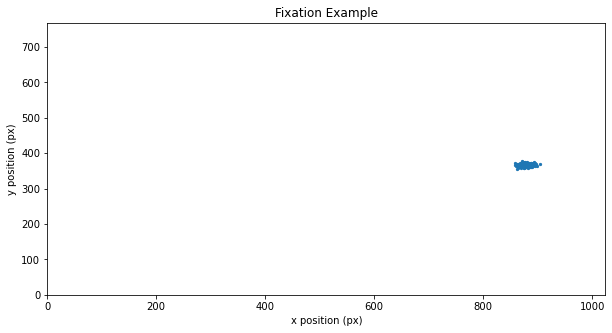

In [17]:
def generate_fixation(fixation_point):
    '''Generate a set of points corresponding to a fixation around fixation_point.
    
    Parameters:
    fixation_point: Point where the fixation is located 
        
    Returns:
    numpy.ndarray: Set of points corresponding to the fixation
    '''
    # Calculate fixation time in seconds within the given range
    fix_time = random.randrange(FIXATION_TIME[0], FIXATION_TIME[1])/1000 # Fixation time in seconds
    # Calculate number of points during the fixation time given the sample rate
    num_of_points = int(fix_time*SAMPLING_RATE) # Number of points during fix_time seconds given a sampling rate
    # List with fixation data
    fixation = []
    # Add random points around the fixation point by adding gaussian noise with
    # the given standard deviation for each axis. This corresponds to the 
    # microsaccades
    for i in range(num_of_points):
        fixX = np.random.normal(fixation_point[0],FIX_NOISE_SD[0])
        fixY = np.random.normal(fixation_point[1],FIX_NOISE_SD[1])
        fixation.append([fixX, fixY])
    # Shape data in the form of [[X points],[Y points]]
    fixation = np.array(fixation).T
    return fixation

# Fixation example around a random point 
point = [random.randint(0, MONITOR_PIXELS[0]), 
           random.randint(0, MONITOR_PIXELS[1])]
data = generate_fixation(point)

# Scatter plot configuration
plt.rcParams['figure.figsize'] = [10, 5]
plt.scatter(data[0], data[1], s=5)
plt.xlim([0,1024])
plt.ylim([0,768])
plt.title("Fixation Example")
plt.xlabel("x position (px)")
plt.ylabel("y position (px)")

### Gaze data generator
This section utilizes the functions of the previous two sections to generate a gaze data set according to the configuration parameters. This section contains one function:

- generate_gaze_data: This function utilizes the *generate_saccade* and *generate_fixation* functions to generate a data set with randomly generated gaze data. It takes a starting point as an argument alongside a configuration argument for cutting down the data to the exact number of points within the given sampling time with the given sampling rate.

At the end of this section, two data visualizations are shown. One is a scatter plot with each point of the generated data set and the other one is a heatmap for visualizing the fixation points.

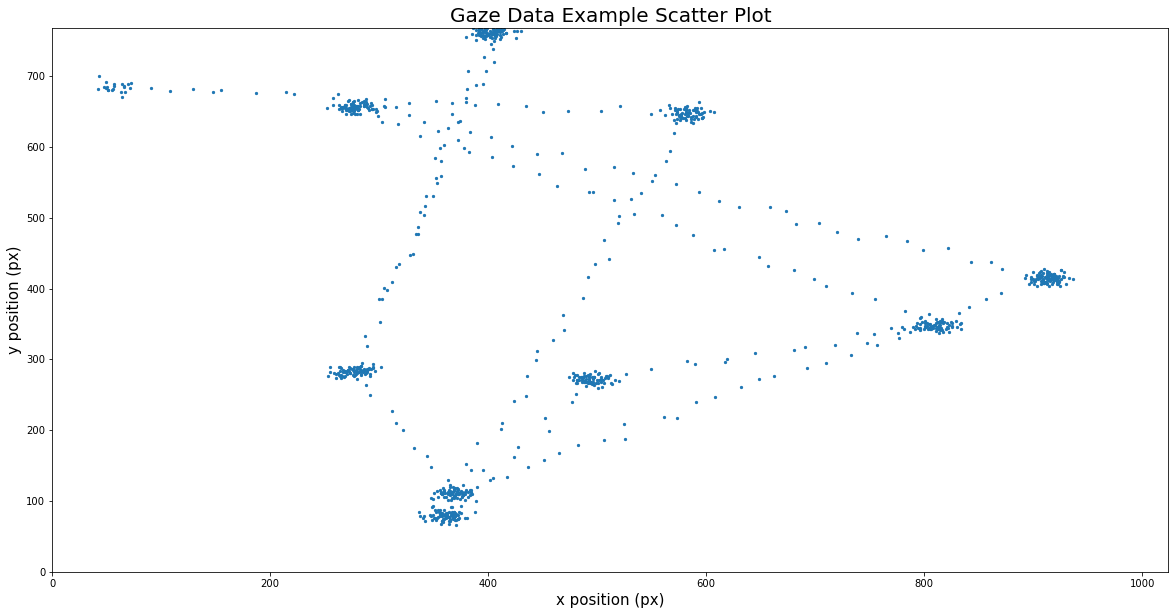

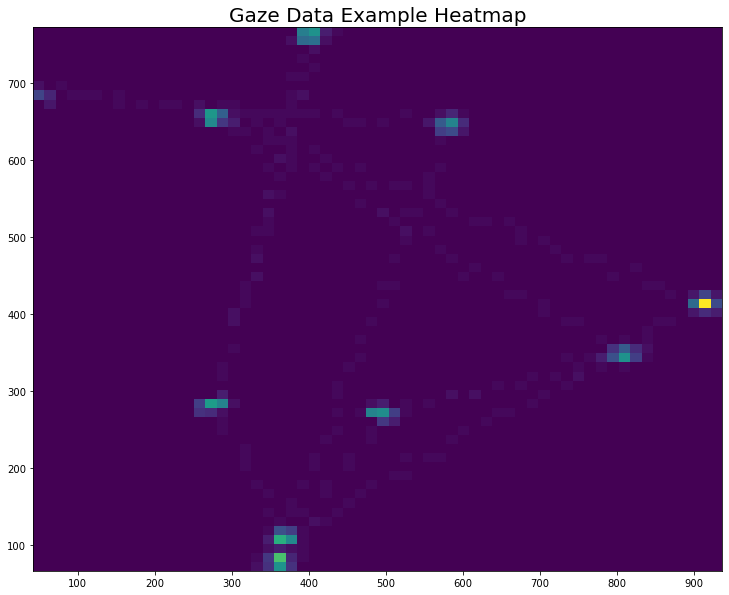

In [18]:
def generate_gaze_data(starting_point, exact=True):
    '''Generate a set of points corresponding to a random set of fixations and
    saccades.
    
    Parameters:
    starting_point: Starting point (coordinates) for the gaze data. 
        
    Returns:
    numpy.ndarray: Set of points corresponding to the gaze data.
    '''
    dataX = np.array([])
    dataY = np.array([])
    curr = starting_point
    # Number of points during SAMPLING_TIME given a SAMPLING_RATE
    num_of_points = SAMPLING_RATE*SAMPLING_TIME
    while dataX.size < num_of_points:
        end = [random.randint(0, MONITOR_PIXELS[0]), 
               random.randint(0, MONITOR_PIXELS[1])]
        saccade = generate_saccade(curr, end)
        fixation = generate_fixation(end)
        dataX = np.concatenate((dataX, saccade[0], fixation[0]))
        dataY = np.concatenate((dataY, saccade[1], fixation[1]))
        curr = end
    # Cut down data set to exactly the number of points in SAMPLING_TIME
    # seconds if specified. Data set is cut by default.
    if exact:
        dataX = dataX[:num_of_points]
        dataY = dataY[:num_of_points]
    # Concatenate X and Y data
    data = np.vstack((dataX, dataY))
    return data

# Gaze data example given a random start point
start = [random.randint(0, MONITOR_PIXELS[0]), 
           random.randint(0, MONITOR_PIXELS[1])]
data =  generate_gaze_data(start)
    
# Scatter plot configuration
plt.rcParams['figure.figsize'] = [20, 10]
plt.scatter(data[0], data[1], s=5)
plt.xlim([0,1024])
plt.ylim([0,768])
plt.title("Gaze Data Example Scatter Plot", fontsize=20)
plt.xlabel("x position (px)", fontsize=15)
plt.ylabel("y position (px)", fontsize=15)
plt.show()

# Heatmap configuration
heatmap, xedges, yedges = np.histogram2d(data[0], data[1], bins=60)
extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]

plt.clf()
plt.imshow(heatmap.T, extent=extent, origin='lower')
plt.title("Gaze Data Example Heatmap", fontsize=20)
plt.show()

### CSV data generator and exporting
In this section, the data generated in the previous section is exported into a CSV file using Pandas. The timestamps for each data point are calculated and added into the original dataset and then the data set is exported as a three column CSV file with the x position, y position and timestamp of the data points as the colums.# Plot configuration 

In [5]:
import pandas as pd 
# Data timestamps
timestamps = []
# Time difference between two samples
time_delta = 1/SAMPLING_RATE
current_time = 0
for i in range(data[0].size):
    timestamps.append(current_time)
    current_time += time_delta

# Add the timestamps and shape the data into two columns
export_data = np.vstack((data, timestamps)).T
pd.DataFrame(export_data).to_csv("./gaze_data.csv",
                                header = ['X Pos', 'Y pos', 'Timestamp'],
                                index=None)

### Questions:
### Q: Using a fixation detection algorithm, how would you now detect the events in your sample data file?

A: Given that the sampling rate requested is relatively low (50 Hz) a dispersion based algorithm may be suitable for the task.